<a href="https://colab.research.google.com/github/taimur1871/image_heatmaps/blob/main/heat_map_obj_detection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating Heatmaps

The workbook uses outputs from a pre trained model to generate heat maps for objects that do not have bounding boxes

If this is no groundtruth (i.e. no bounding boxes have been annotated), it is still possible to be able to generate Object detector using the Saliency heatmaps generates out of the convolutional layers of a classifier (like AlexNet, Imagenet, Inception etc).

We will generate an object detector for "dog" using the heatmaps from a Classification Model. 

Using models from https://keras.io/api/applications/ (Links to an external site.). 

The classifier will not need to be retrained.


In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import decode_predictions
from tensorflow.keras.backend import gradients, mean
from tensorflow import GradientTape

%matplotlib inline

In [2]:
from tensorflow.keras.applications import EfficientNetB5

## Load Model

Use any model from the tf.keras.application models

In [3]:
model = EfficientNetB5(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

123469824/123465288 [==============================] - 4s 0us/step


In [4]:
# summarize the model and find the last conv layer
model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 456, 456, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 456, 456, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 457, 457, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

## Loading & Processing Images

The functions below load and preprocess images for the model. This version is using efficientnet b5 which takes an input of size (456,456,3)

In [94]:
# define image directory, replace this with any directory you want to test
img_dir = '/content/drive/MyDrive/4BAI/week 6 class/dog_dataset/images'
list_imgs = os.listdir(img_dir)

In [91]:
# function to load images
def load_images(img_path):
  img = image.load_img(img_path, target_size=(456,456))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  return x

### Cover image with heat map

In [102]:
# function to cover image with heat map
def cover_img(img_path, heatmap):
  # Use cv2 to load the original image
  img_original = cv2.imread(img_path)

  # set the intensity map at 0.5
  INTENSITY = 0.5

  # Resize the heatmap to have the same size as the original image
  heatmap_resized = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

  # Convert the heatmap to RGB
  heatmap_resized = np.uint8(255 * heatmap_resized)

  # We apply the heatmap to the original image
  heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

  # processed image
  img_new = heatmap_resized * INTENSITY + img_original

  return img_new

### Get threshold heatmap
This function also returns the htmp array which will be used to find the coordinates

In [167]:
def threshold_htmp(heatmap, img_path):
  img_dim = cv2.imread(img_path)
  ht = img_dim.shape[1]
  wd = img_dim.shape[0]
  
  
  htmp = heatmap.copy()
  htmp = cv2.resize(htmp, (ht, wd))

  # refactoring heatmap
  threshold = 0.5
  htmp[htmp > threshold] = 1
  htmp[htmp < threshold] = 0

  # show heatmaps
  plt.matshow(htmp)
  plt.colorbar()
  plt.show()

  return htmp

In [129]:
def find_coordinate(htmp):
  # finding all indices where array element is 1
  t = np.argwhere(htmp == 1)

  # finding coordinates
  ymin, ymax = min(t[:,0]), max(t[:,0])
  xmin, xmax = min(t[:,1]), max(t[:,1])

  return xmin, ymin, xmax, ymax

### Function to draw bounding boxes

In [106]:
# functions for bounding boxes
def plot_bbox(img, boxes, classes, scores):
  source_img = Image.open(img)

  xmin, ymin, xmax, ymax = boxes

  draw = ImageDraw.Draw(source_img)
  draw.rectangle(((xmin, ymin), (xmax, ymax)), fill=None, outline='blue', width=2)
  draw.text((xmin+10, ymin+10), str(classes) + str(scores))

  return source_img

## Test Images
Finally test the functions on all images. We will also save all the bounding boxes with the file names in a dict.

In [152]:
temp_htmp.shape

(1, 456)

In [ ]:
bbox = {}
# please note that to test faster only 5 images have been processed here, 
# to process all pictures change the list_imgs[:5] with list_imgs
for pic in list_imgs:
  pic_path = os.path.join(img_dir, pic)
  print(pic_path)
  
  # load each image to pass to model to make predictions
  img_temp = load_images(pic_path)
  preds = model.predict(img_temp)

  # creating heat maps
  with GradientTape() as tape:
    # getting the last conv layer of the model, might have to change this to a layer above
    last_conv_layer = model.get_layer('top_conv')

    # iterate will allow us to access the values of the quatities defined below i.e.
    # pooled_grads and the outputs of the last conv layer
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(img_temp)
    class_out = model_out[:, np.argmax(model_out[0])]

    # calculate teh gradients of the class wrt to last layer
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = mean(grads, axis=(0, 1, 2))

  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

  # plot original heatmap
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  # the reshape value will very if a different model is used since the shape 
  # depends on the output of the final conv layer, so make changes accordingly
  heatmap = heatmap.reshape((15, 15))
  plt.matshow(heatmap)
  plt.colorbar()
  plt.show()

  # plot the threshold map and get coordinates for the bounding boxes
  temp_htmp = threshold_htmp(heatmap, pic_path)
  xmin, ymin, xmax, ymax = find_coordinate(temp_htmp)

  # shows image covered with heat map
  cv2_imshow(cover_img(pic_path, heatmap))

  # get class and scores for bounding boxes
  classes = decode_predictions(preds, top=1)[0]
  cls = classes[0][1]
  score = classes[0][2]

  img_bb = plot_bbox(pic_path, (xmin,ymin,xmax,ymax), cls, score)

  fig = plt.figure(figsize=(10,8))
  plt.imshow(img_bb)

  bbox[pic] = [xmin, ymin, xmax, ymax]

## Observations

The method works overall, the threshold for heatmap is crucial. If it is set too high most of the pixels will get converted to 0 and not included in bounding boxes. If too low then the bounding boxes might become too big.

## Finding IOU Scores

Use tf iou function to calculate IOU scores

In [ ]:
# function to read xml files


In [ ]:
# getting actual bounding boxes from xml files
## TODO ##

# getting bounding boxes from the results above
## TODO ##

# updating the score
t_gt_boxes[t_gt_boxes >= 1.0] = 0.99
metric = tf.keras.metrics.MeanIoU(num_classes=1)
########START CODE HERE
for i in range(0, t_gt_boxes.shape[0]):
    print(i)
    try:
        metric.update_state(t_gt_boxes[i], preds[i][0])
    except IndexError: # this accounts for any picutres where no detections were made as that is going to be an empty array
        continue

m=metric.result().numpy()
########END CODE HERE
print('Mean IOU=',m)

## Expanding to the other animals dataset

Now we will analyze the images in other animal dataset.

In [171]:
# define image directory, replace this with any directory you want to test
img_dir = '/content/drive/MyDrive/4BAI/week 6 class/animals'
list_imgs = os.listdir(img_dir)

/content/drive/MyDrive/4BAI/week 6 class/animals/ferret.jpg


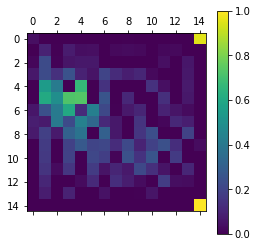

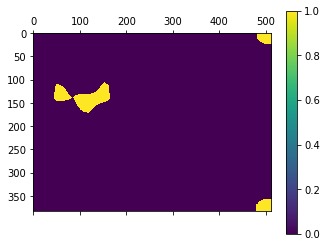

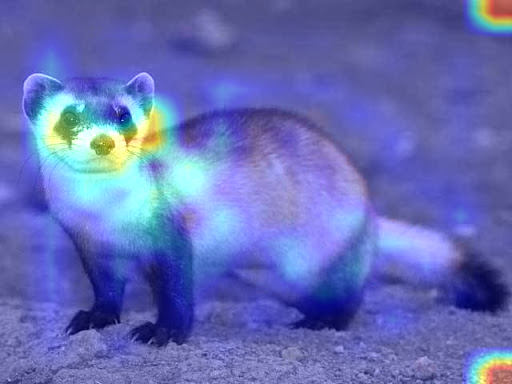

/content/drive/MyDrive/4BAI/week 6 class/animals/raccon.jpg


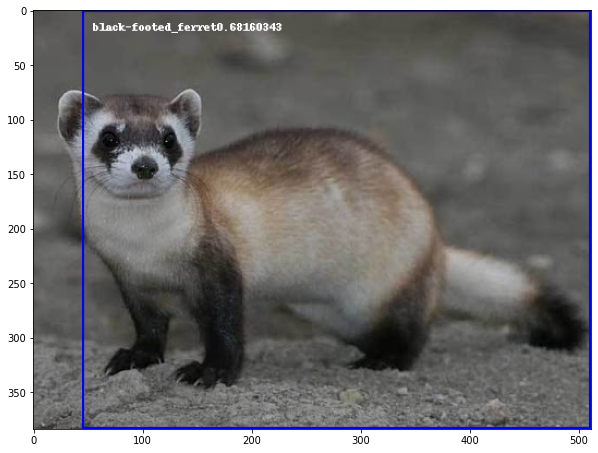

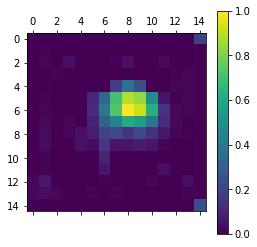

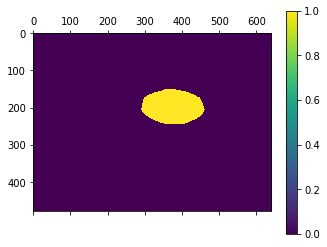

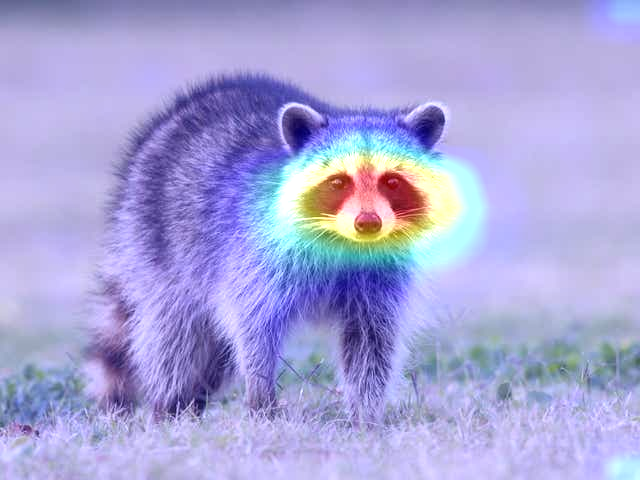

/content/drive/MyDrive/4BAI/week 6 class/animals/rabbit.jpg


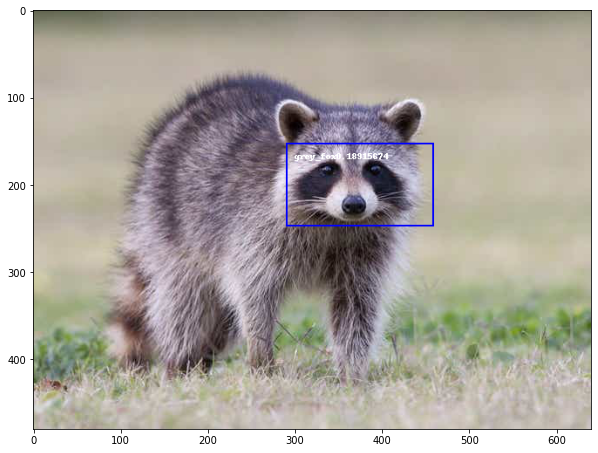

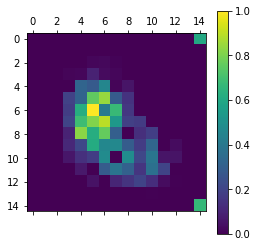

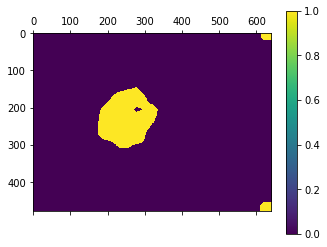

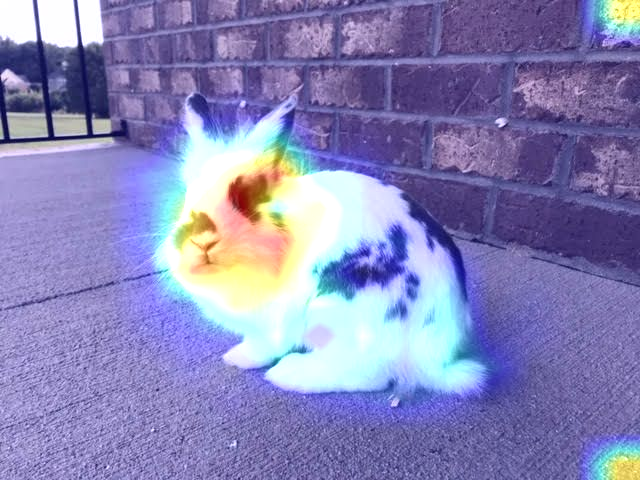

/content/drive/MyDrive/4BAI/week 6 class/animals/mouse.jpg


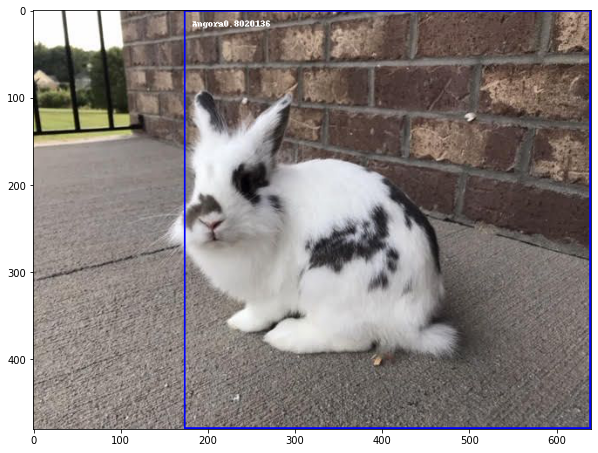

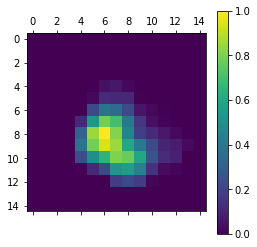

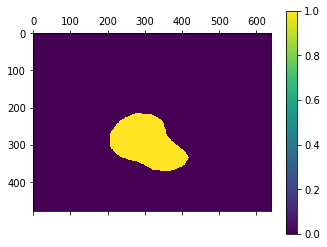

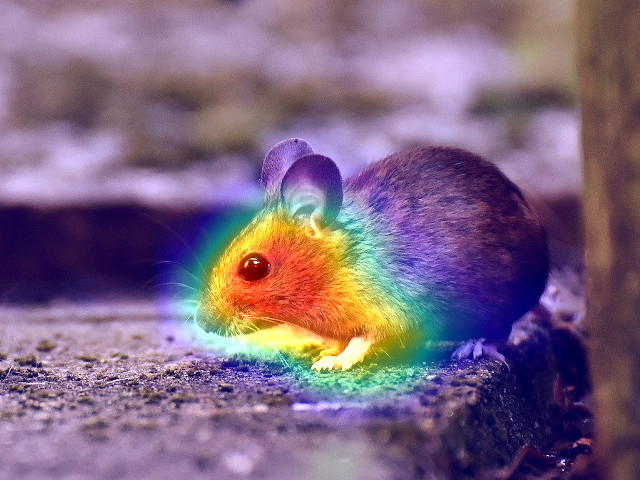

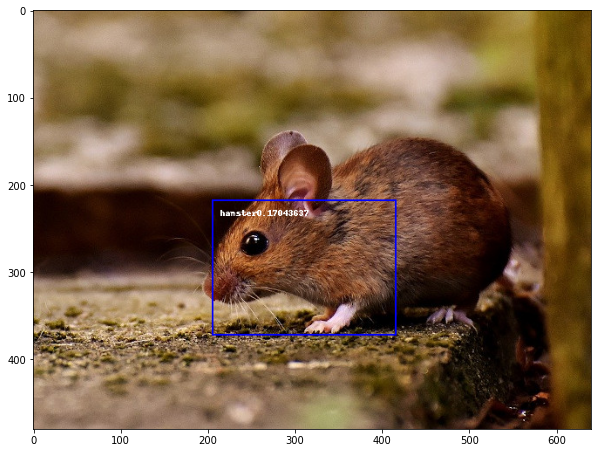

In [172]:
# please note that to test faster only 5 images have been processed here, 
# to process all pictures change the list_imgs[:5] with list_imgs
for pic in list_imgs:
  pic_path = os.path.join(img_dir, pic)
  print(pic_path)
  
  # load each image to pass to model to make predictions
  img_temp = load_images(pic_path)
  preds = model.predict(img_temp)

  # creating heat maps
  with GradientTape() as tape:
    # getting the last conv layer of the model, might have to change this to a layer above
    last_conv_layer = model.get_layer('top_conv')

    # iterate will allow us to access the values of the quatities defined below i.e.
    # pooled_grads and the outputs of the last conv layer
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(img_temp)
    class_out = model_out[:, np.argmax(model_out[0])]

    # calculate teh gradients of the class wrt to last layer
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = mean(grads, axis=(0, 1, 2))

  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

  # plot original heatmap
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  # the reshape value will very if a different model is used since the shape 
  # depends on the output of the final conv layer, so make changes accordingly
  heatmap = heatmap.reshape((15, 15))
  plt.matshow(heatmap)
  plt.colorbar()
  plt.show()

  # plot the threshold map and get coordinates for the bounding boxes
  temp_htmp = threshold_htmp(heatmap, pic_path)
  xmin, ymin, xmax, ymax = find_coordinate(temp_htmp)

  # shows image covered with heat map
  cv2_imshow(cover_img(pic_path, heatmap))

  # get class and scores for bounding boxes
  classes = decode_predictions(preds, top=1)[0]
  cls = classes[0][1]
  score = classes[0][2]

  img_bb = plot_bbox(pic_path, (xmin,ymin,xmax,ymax), cls, score)

  fig = plt.figure(figsize=(10,8))
  plt.imshow(img_bb)